# Model Prediction Step (Etapa da Previsão do Modelo)
## Table of Contents
* [Packages](#1)
* [Load Utils Functions](#2)
    * [Request User](#2.1)
    * [Create Playlist](#2.2)
    * [Add Tracks](#2.3)
* [Load Model](#3)
* [Prediction](#4)
    * [Prediction with Model Only](#4.1)
    * [Cosine Similarity Prediction](#4.2)
        * [PCA](#4.3)
* [Recommendation](#5)
    * [Environment Variables](#5.1)
    * [Request Authorization](#5.2)
    * [Playlist Definition](#5.3)
    * [Extract, Transform and Preprocessing the Data](#5.4)
    * [Inference](#5.5)
* [Load Tracks](#6)

<a class="anchor" id="1"></a>
## Packages (Pacotes)
**[EN-US]**

Packages used in the system.
* [os](https://docs.python.org/3/library/os.html): built-in module, provides a portable way of using operating system dependent functionality;
* [sys](https://docs.python.org/3/library/sys.html): provides access to some variables used or maintained by the interpreter and to functions that interact strongly with the interpreter;
* [requests](https://pypi.org/project/requests/): is a simple HTTP library, for making HTTP requests;
* [pandas](https://pandas.pydata.org/): is the main package for data manipulation;
* [numpy](www.numpy.org): is the main package for scientific computing;
* [tensorflow](https://www.tensorflow.org/): framework that makes it easy to create ML models that can run in any environment;
* [scikit-learn](https://scikit-learn.org/stable/): open source machine learning library;
* [utils](../utils/): system utility functions;
* [matplotlib](http://matplotlib.org): is a library to plot graphs;
* [plotly](https://plotly.com/python/): makes interactive, publication-quality graphs;
* [warnings](https://docs.python.org/pt-br/3/library/warnings.html): controls whether warnings are ignored, displayed, or turned into errors (raising an exception).

**[PT-BR]**

Pacotes utilizados no sistema.
* [os](https://docs.python.org/3/library/os.html): módulo integrado, fornece uma maneira portátil de usar funcionalidades dependentes do sistema operacional;
* [sys](https://docs.python.org/3/library/sys.html): fornece acesso a algumas variáveis usadas ou mantidas pelo interpretador e a funções que interagem fortemente com o interpretador;
* [requests](https://pypi.org/project/requests/): é uma biblioteca HTTP simples, para fazer solicitações HTTP;
* [pandas](https://pandas.pydata.org/): é o principal pacote para manipulação de dados;
* [numpy](www.numpy.org): é o principal pacote para computação científica;
* [tensorflow](https://www.tensorflow.org/): framework que facilita a criação de modelos de machine learning que podem ser executados em qualquer ambiente;
* [scikit-learn](https://scikit-learn.org/stable/): biblioteca open-source de machine learning;
* [utils](../utils/): funções utilitárias do sistema;
* [matplotlib](http://matplotlib.org): é uma biblioteca para plotar gráficos;
* [plotly](https://plotly.com/python/): cria gráficos interativos com qualidade de publicação;
* [warnings](https://docs.python.org/pt-br/3/library/warnings.html): controla se os avisos são ignorados, exibidos ou transformados em erros (gerando uma exceção).

In [49]:
import os
import sys
from requests import get, post

import pandas as pd
import numpy as np
import numpy.ma as ma
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.backend import clear_session
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

PROJECT_ROOT = os.path.abspath( # Getting Obtaining the absolute normalized version of the project root path (Obtendo a versão absoluta normalizada do path raíz do projeto)
    os.path.join( # Concatenating the paths (Concatenando os paths)
        os.getcwd(), # # Getting the path of the notebooks directory (Obtendo o path do diretório dos notebooks)
        os.pardir # Gettin the constant string used by the OS to refer to the parent directory (Obtendo a string constante usada pelo OS para fazer referência ao diretório pai)
    )
)
# Adding path to the list of strings that specify the search path for modules
# Adicionando o path à lista de strings que especifica o path de pesquisa para os módulos
sys.path.append(PROJECT_ROOT)
from utils.ingestion_utils import request_auth, playlist_to_dataframe
from utils.preprocessing_utils import get_user_dataset
from utils.model_utils import model_compile

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 15) # set default size of plots (definindo o tamanho padrão dos plots)
import plotly.express as px

from warnings import simplefilter
simplefilter('ignore')

Checking tensorflow version (Verificando a versão do tensorflow).

In [52]:
tf.__version__

'2.18.0'

<a name="2"></a>
## Load Utility Functions (Funções Utilitárias de Carregamento)
**[EN-US]**

Utility functions for requesting the user ID, creating the playlist and loading recommended songs into the playlist. The `get_user` function makes the request to obtain the user ID, the `create_playlist` function creates the playlist where the recommended songs will be added and the `add_tracks` function adds the songs to a playlist.

**[PT-BR]**

Funções utilitárias para a requisição do ID do usuário, criação da playlist e carregamento das músicas recomendadas na playlist. A função `get_user` faz a requisição para obter o ID do usuário, a função `create_playlist` cria a playlist onde as músicas recomendadas serão adicionadas e a função `add_tracks` adiciona as músicas em uma playlist.

<a name="2.1"></a>
### Request User (Requisita o Usuário)
**[EN-US]**

Utility function to request user ID to create playlist later.

**[PT-BR]**

Função utilitária para requisitar o ID do usuário para criar a playlist posteriormente.

In [60]:
def get_user(token_type, access_token):
    """
    [EN-US]
    Requests user data.
    
    [PT-BR]
    Requisita os dados do usuário.
    
    Arguments:
        token_type -- How the access token may be used: always "Bearer"
                      (Como o token de acesso pode ser utilizado: sempre “Bearer”).
        access_token -- An access token that can be provided in subsequent calls, for example to Spotify Web API services
                        (Um token de acesso que pode ser fornecido em chamadas subsequentes, por exemplo, para serviços Spotify Web API).
    
    Return:
        response.json()['id'] -- User ID (ID do usuário).
    """
    # Setting options for the request (Definindo as opções para a requisição)
    endpoint = f'https://api.spotify.com/v1/me'
    headers = {'headers': {
        'Authorization': token_type + ' ' + access_token
    }}
    
    # Send a get request (Enviando a requisição get)
    response = get(url=endpoint, headers=headers['headers'])
    # If the request status code is not 200 (Caso o status code da requisição não seja 200)
    if response.status_code != 200:
        print('Error! User data not extracted.')
    
    return response.json()['id']

<a name="2.2"></a>
### Create Playlist (Cria a Playlist)
**[EN-US]**

Utility function to create a playlist where recommended songs will be added.

**[PT-BR]**

Função utilitária para criar uma playlist onde as músicas recomendadas serão adicionadas.

In [63]:
def create_playlist(user_id, token_type, access_token, name='RecSys', description='Recommended tracks'):
    """
    [EN-US]
    Create a new playlist in the Spotify app.
    
    [PT-BR]
    Cria uma nova playlist no Spotify app.
    
    Arguments:
        user_id -- User ID where the playlist will be created
                    (ID do usuário onde será criada a playlist).
        token_type -- How the access token may be used: always "Bearer"
                      (Como o token de acesso pode ser utilizado: sempre “Bearer”).
        access_token -- An access token that can be provided in subsequent calls, for example to Spotify Web API services
                        (Um token de acesso que pode ser fornecido em chamadas subsequentes, por exemplo, para serviços Spotify Web API).
        name -- The name of the playlist that will be created (O nome da playlist que será criada).
        description -- The description of the playlist that will be created (A descrição da playlist que será criada).
    
    Return:
        response.json()['id'] -- New playlist ID (ID da nova playlist).
    """
    # Setting options for the request (Definindo as opções para a requisição)
    url = f'https://api.spotify.com/v1/users/{user_id}/playlists'
    playlist_options = {
        'headers': {
            'Authorization': token_type + ' ' + access_token,
            'Content-Type': 'application/json'
        },
        'data': {
            'name': name,
            'description': description,
            'public': True,
            'collaborative': False
        }
    }
    
    # Send a post request (Enviando a requisição post)
    request = post(url=url, headers=playlist_options['headers'], data=playlist_options['data'])
    # If the request status code is 200 (Caso o status code da requisição for 200)
    if request.status_code == 200:
        print('Playlist created successfully!')
    else:
        print('Playlist creation not authorized!')

    return request.json()['id']

<a name="2.3"></a>
### Add Tracks (Adiciona as Tracks)
**[EN-US]**

Utility function to add recommended tracks to a playlist.

**[PT-BR]**

Função utilitária para adicionar as tracks recomendadas em uma playlist.

In [66]:
def add_tracks(playlist_id, uris, token_type, access_token, position=0):
    """
    [EN-US]
    Adds recommended songs to a playlist.
    
    [PT-BR]
    Adiciona as músicas recomendadas em uma playlist.
    
    Arguments:
        playlist_id -- ID of the playlist where the songs will be added
                    (ID da playlist onde as músicas serão adicinadas).
        uris -- A list of Spotify URIs to add, can be track or episode URIs
                (Uma lista de URIs do Spotify para adicionar, podem ser URIs de track ou episódio).
        token_type -- How the access token may be used: always "Bearer"
                      (Como o token de acesso pode ser utilizado: sempre “Bearer”).
        access_token -- An access token that can be provided in subsequent calls, for example to Spotify Web API services
                        (Um token de acesso que pode ser fornecido em chamadas subsequentes, por exemplo, para serviços Spotify Web API).
        position -- The position to insert the items, a zero-based index
                    (A posição para inserir os itens, um índice de base zero).
    """
    # Setting options for the request (Definindo as opções para a requisição)
    url = f'https://api.spotify.com/v1/playlists/{playlist_id}/tracks'
    playlist_options = {
        'headers': {
            'Authorization': token_type + ' ' + access_token,
            'Content-Type': 'application/json'
        },
        'data': {
            'uris': uris,
            'position': position
        }
    }
    
    # Send a post request (Enviando a requisição post)
    request = post(url=url, headers=playlist_options['headers'], data=playlist_options['data'])
    # If the request status code is 200 (Caso o status code da requisição for 200)
    if request.status_code == 200:
        print('Tracks added to playlist successfully!')
    else:
        print('Error! Tracks not added to playlist.')

<a name="3"></a>
## Load Model
**[EN-US]**

The model used for the recommendation system was the `Content-Based Filtering` algorithm.

**[EN-US]**

O modelo utilizado para o sistema de recomendação foi o algoritmo `Content-Based Filtering`.

Reading pre-processed datasets (Lendo os datasets pré-processados).

In [70]:
item_train_norm = pd.read_csv('../data/preprocessed/item_train_norm.csv')
user_train_norm = pd.read_csv('../data/preprocessed/user_train_norm.csv')

item_cv_norm = pd.read_csv('../data/preprocessed/item_cv_norm.csv')
user_cv_norm = pd.read_csv('../data/preprocessed/user_cv_norm.csv')

item_test_norm = pd.read_csv('../data/preprocessed/item_test_norm.csv')
user_test_norm = pd.read_csv('../data/preprocessed/user_test_norm.csv')

items = pd.read_csv('../data/transformed/items.csv')

Defining the number of features for the user and item neural network (Definindo o número de features para a rede neural do usuário e do item).

In [73]:
num_user_features, num_item_features = user_train_norm.shape[1], item_train_norm.shape[1]
print(f'num_user_features: {num_user_features}\nnum_item_features: {num_item_features}')

num_user_features: 13
num_item_features: 23


Loading the pre-trained model (Carregando o modelo pré-treinado).

In [76]:
OPT = Adam()
LOSS = MeanSquaredError()

model = model_compile(OPT, LOSS, num_user_features, num_item_features)
model.load_weights('../model/pretrained.weights.h5')
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_NN             │ (None, 32)        │     47,958 │ input_layer[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_NN             │ (None, 32)        │     50,518 │ input_layer_2[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l2__norm (L2_Norm)  │ (None, 32)        │          0 │ user_NN[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l2__norm_1          │ (None, 32)        │          0 │ item_NN[0][0]     │
│ (L2_Norm)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 1)         │          0 │ l2__norm[0][0],   │
│                     │                   │            │ l2__norm_1[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 98,476 (384.67 KB)

 Trainable params: 96,692 (377.70 KB)

 Non-trainable params: 1,784 (6.97 KB)

<a name="4"></a>
## Prediction (Previsão)
**[EN-US]**

Calculating the model's prediction on the training, validation and test data, because this is already the final model.

**[PT-BR]**

Calculando a previsão do modelo sobre os dados de treino, de validação e de teste, porque este já é o modelo final.

<a name="4.1"></a>
### Prediction with Model Only (Previsão Apenas com o Modelo)
**[EN-US]**

Using only the trained model to calculate the prediction on the training, validation and test data.

**[PT-BR]**

Utilizando apenas o modelo treinado para calcular a previsão sobre os dados de treino, validação e teste.

Performing prediction on training data (Realizando a previsão sobre os dados de treino).

In [35]:
y_hat_train = model.predict([user_train_norm, item_train_norm], verbose=0)
y_hat_train[:10]

array([[ 0.00331223],
       [-0.02190151],
       [ 0.9983406 ],
       [ 0.99897605],
       [-0.02286294],
       [ 0.9982052 ],
       [ 0.9962521 ],
       [ 0.9992017 ],
       [ 0.99901867],
       [-0.02848413]], dtype=float32)

Plotting the top $m$ recommendations on the training data (Plotando as $m$ primeiras recomendações sobre os dados de treino).

In [38]:
m = 10

# Sorting the vector with the predictions in descending order and selecting only the indexes
# Ordenando o vetor com as previsões em ordem decrescente e selecionando apenas os índices
sorted_idx_train = np.argsort(-y_hat_train, axis=0).squeeze().tolist()
# Slicing the recommended training indices from the items dataset and sorting them in the same order
# Selecionando os índices de treino recomendados no dataset de items e os ordenando na mesma ordem
sorted_items_train = items.iloc[sorted_idx_train].copy()
# Plotting the top m recommended items
# Plotando os top m items recomendados
sorted_items_train.head(m)

,id,name,artists
293,37EJtTS7jT5WUyXGZzrwnI,Santa Monica,Everclear
105,6gZVQvQZOFpzIy3HblJ20F,Man in the Box,Alice In Chains
509,6Zo58fraaPpTUUdYHwH0sf,Por Enquanto - Ao Vivo,Cássia Eller
294,70wYA8oYHoMzhRRkARoMhU,When You Were Young,The Killers
556,2fYq0QnkfHuNSlZqc8qgv7,When You're Gone - Acoustic Version,Avril Lavigne
312,0cuq829zRNq4AEdmDJA4aw,Two Princes,Spin Doctors
88,3bQmU3UGvZMsYZ13ffNyVf,Você Não Soube Me Amar,Blitz
23,67vYdAAM3oGsEImCRfbtsF,Times Like These,Foo Fighters
446,6Bg8wr9A4pEQu98f2WMJJp,Dance Of Death,Iron Maiden
98,5qqabIl2vWzo9ApSC317sa,Wonderwall - Remastered,Oasis


Performing prediction on the validation data (Realizando a previsão sobre os dados de validação).

In [41]:
y_hat_cv = model.predict([user_cv_norm, item_cv_norm], verbose=0)
y_hat_cv[:10]

array([[-0.02706262],
       [-0.04229252],
       [ 0.9993335 ],
       [-0.01447624],
       [ 0.99659073],
       [ 0.9950178 ],
       [ 0.99867547],
       [ 0.99886936],
       [-0.0338176 ],
       [ 0.99633646]], dtype=float32)

Plotting the top $m$ recommendations on the validation data (Plotando as $m$ primeiras recomendações sobre os dados de validação).

In [44]:
m = 10

# Sorting the vector with the predictions in descending order and selecting only the indexes
# Ordenando o vetor com as previsões em ordem decrescente e selecionando apenas os índices
sorted_idx_cv = np.argsort(-y_hat_cv, axis=0).squeeze().tolist()
# Slicing the recommended validation indices from the items dataset and sorting them in the same order
# Selecionando os índices de validação recomendados no dataset de items e os ordenando na mesma ordem
sorted_items_cv = items.iloc[sorted_idx_cv].copy()
# Plotting the top m recommended items
# Plotando os top m items recomendados
sorted_items_cv.head(m)

,id,name,artists
164,6UyPTgKXxsFeQExGml9x21,Take On Me - MTV Unplugged / Edit,a-ha
92,4VqPOruhp5EdPBeR92t6lQ,Uprising,Muse
71,3nlGByvetDcS1uomAoiBmy,The Number of the Beast - 2015 Remaster,Iron Maiden
148,0qgiFuYhYuwtFXEwYakddE,I Will Survive,CAKE
56,0JSux25Te5HYMSr2D64d02,Levanta e Anda,Emicida
25,3ftHrCjsTUPLgI48m67byk,Plush - Acoustic,Stone Temple Pilots
177,0YBq701BXkMaK6V5UyvOpT,Oração,A Banda Mais Bonita da Cidade
64,23oxJmDc1V9uLUSmN2LIvx,Ocean Avenue,Yellowcard
84,4OQCnf6Jx0cZzzTh7fU0TF,O Nosso Amor A Gente Inventa (Estória Romântica),Cazuza
2,6jBZxE0VZpmgZud4L5lo0u,Paparico,Molejo


Performing prediction on test data (Realizando a previsão sobre os dados de teste).

In [47]:
y_test = pd.read_csv('../data/preprocessed/y_test.csv')

test_eval = model.evaluate([user_test_norm, item_test_norm], y_test, verbose=0)
print(f'Test set evaluation: {test_eval[0]:.2f}')

y_hat_test = model.predict([user_test_norm, item_test_norm], verbose=0)
y_hat_test[:10]

Test set evaluation: 0.01


array([[ 0.02060999],
       [-0.0058764 ],
       [-0.00628444],
       [ 0.9981637 ],
       [-0.05289307],
       [-0.05455515],
       [ 0.99827844],
       [ 0.02802315],
       [ 0.00122957],
       [ 0.9962109 ]], dtype=float32)

Plotting the top $m$ recommendations on the test data (Plotando as $m$ primeiras recomendações sobre os dados de teste).

In [49]:
m = 10

# Sorting the vector with the predictions in descending order and selecting only the indexes
# Ordenando o vetor com as previsões em ordem decrescente e selecionando apenas os índices
sorted_idx_test = np.argsort(-y_hat_test, axis=0).squeeze().tolist()
# Slicing the recommended test indices from the items dataset and sorting them in the same order
# Selecionando os índices de teste recomendados no dataset de items e os ordenando na mesma ordem
sorted_items_test = items.iloc[sorted_idx_test].copy()
# Plotting the top m recommended items
# Plotando os top m items recomendados
sorted_items_test.head(m)

,id,name,artists
73,1aZvj0eDYyJwwY0cH008xM,Harakiri,Serj Tankian
166,2ihCaVdNZmnHZWt0fvAM7B,Little Talks,Of Monsters and Men
42,38jy6kRlPt8z1GUS9WXeNh,93 Million Miles,Jason Mraz
193,2YSbHu9XF4bNYWt3MnIhgE,Bohemian Rhapsody,Panic! At The Disco
181,5MYsvAONqcsIVOwu2HTQ3p,Faith,Limp Bizkit
67,0EYOdF5FCkgOJJla8DI2Md,B.Y.O.B.,System Of A Down
183,6gCVA6ja6g0foIsWv0RuSZ,ATWA,System Of A Down
132,6LhN47wHHsSzlbVzsXe7cY,California Waiting,Kings of Leon
143,1IWom0fqK0dJKITk1H95BB,Go,The Black Keys
103,3lPr8ghNDBLc2uZovNyLs9,Supermassive Black Hole,Muse


<a name="4.2"></a>
### Cosine Similarity Prediction (Previsão com a Similaridade de Cosseno)
**[EN-US]**

The neural network computes 2 feature vectors, the user's feature vector $\vec{v}_u$ and the item's feature vector $\vec{v}_r$. Therefore, similar items will have similar vectors $\vec{v}$, so this information can be used to make recommendations.

We can use cosine similarity to find items similar to item $i$. Cosine similarity is a similarity metric. It uses the cosine of the angle between 2 vectors. Based on this, it tells whether 2 vectors are close or not by calculating the cosine of their internal angle. The measure of cosine similarity between vectors $v_r^{(k)}$ and $v_r^{(i)}$:
$$\cos{\beta} = \frac{v_r^{(k)} . v_r^{(i)}}{||v_r^{(k)}|| \times ||v_r^{(i)}||}$$
Where:
* $v_r^{(k)} . v_r^{(i)}$: dot product between 2 vectors.
* $||v_r^{(i)}||$: norm or magnitude of the vector $v_r^{(i)}$.

**[PT-BR]**

A rede neural calcula 2 vetores de features, o vetor de features do usuário $\vec{v}_u$ e o vetor de features do item $\vec{v}_r$. Portanto, itens similares terão vetores $\vec{v}$ similares, então, essa informação pode ser usada para fazer recomendações.

Podemos utilizar a similaridade de cosseno para encontrar itens similares ao item $i$. A similaridade de cosseno é uma métrica de similaridade. Ela faz o uso do cosseno do ângulo entre 2 vetores. Com base nisso, ela informa se 2 vetores estão próximos ou não calculando o cosseno de seu ângulo interno. A medida da similaridade de cosseno entre os vector $v_r^{(k)}$ e $v_r^{(i)}$:
$$\cos{\beta} = \frac{v_r^{(k)} . v_r^{(i)}}{||v_r^{(k)}|| \times ||v_r^{(i)}||}$$
Onde:
* $v_r^{(k)} . v_r^{(i)}$: dot product entre 2 vetores.
* $||v_r^{(i)}||$: norma ou magnitude do vetor $v_r^{(i)}$.

Setting the model using only the item neural network (Definindo o modelo usando apenas a rede neural do item).

In [35]:
LOSS_ITEM = MeanSquaredError()

model_item = model_compile(OPT, LOSS_ITEM, num_user_features, num_item_features, item_similarity=True)
model_item.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 23)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ item_NN (Sequential)            │ (None, 32)             │        50,518 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l2__norm_1 (L2_Norm)            │ (None, 32)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,518 (197.34 KB)

 Trainable params: 49,626 (193.85 KB)

 Non-trainable params: 892 (3.48 KB)

Collecting the item network weights from the pre-trained complete neural network and setting them in the new network (Coletando os pesos da rede do item, da rede neural completa pré-treinada e definindo na nova rede).

In [38]:
item_nn_weights = model.get_layer('item_NN').get_weights()
model_item.get_layer('item_NN').set_weights(item_nn_weights)

We calculate the mean and standard deviation of the training set, and then apply the z-score to the full dataset with the mean and standard deviation of the training set (Calculamos a média e desvio-padrão do training set, e então, aplicamos o z-score para o dataset de completo com a média e o desvio-padrão do training set).
$$X = \frac{X - \mu}{\sigma^2}$$
* $\mu$: mean (média).
* $\sigma^2$: standard deviation (desvio-padrão).

Scaling the complete item matrix and calculating the feature vector of all items (Escalando a matriz de itens completa e calculando o vetor de features de todos os itens).

In [42]:
X_pre = pd.read_csv('../data/preprocessed/X_pre.csv')
X_scaler = StandardScaler()
X_norm = X_scaler.fit_transform(X_pre)

item_feature_vectors = model_item.predict(X_norm, verbose=0)
print(f'Size of all predicted item feature vectors: {item_feature_vectors.shape}')

Size of all predicted item feature vectors: (982, 32)


Computing cosine similarity for all items (Calculando a similaridade de cosseno para todos os itens).

In [597]:
dim = item_feature_vectors.shape[0]
cos_sim = np.zeros((dim, dim))

# Looping through all items and calculating the cosine similarity between each different item
# Percorrendo todos os itens e calculando a similaridade de cosseno entre cada item diferente
for i in range(dim):
    for j in range(dim):
        cos_sim[i, j] = cosine_similarity(
            item_feature_vectors[i, :].reshape(1, -1),
            item_feature_vectors[j, :].reshape(1, -1)
        )
# Avoiding selecting the same item. The masked values along the diagonal won't be included in the computation
# Evitando selecionar o mesmo item. Os valores mascarados ao longo da diagonal não serão incluídos no cálculo
m_cos_sim = ma.masked_array(cos_sim, mask=np.identity(dim))

# Number of recommended tracks to be added to the playlist
# Quantidade de tracks recomendadas para ser adicionada à playlist 
m = 20
# List to store the indexes, to add to the playlist later
# Lista para armazenar os índices, para adicionar à playlist posteriormente
idx = []
# List to store each example
# Lista para armazenar cada exemplo
data = []
# Looping through each example and selecting the index of the most similar vector
# Percorrendo cada exemplo e selecionando o índice do vetor mais similar
for i in range(dim):
    max_idx = np.argmax(m_cos_sim[i])
    example = [
        items.loc[i, 'name'],
        items.loc[i, 'artists'],
        items.loc[max_idx, 'name'],
        items.loc[max_idx, 'artists']
    ]
    data.append(example)
    if i < m:
        idx.append(max_idx)

# Creating the dataframe with the items and their most similar items
# Criando o dataframe com os itens e seus itens mais similares
features = ['name_root', 'artists_root', 'name_recommended', 'artists_recommended']
cos_sim_rec = pd.DataFrame(data, columns=features)

In [598]:
# Number of items to display (Número de itens a serem exibidos)
m = 20
cos_sim_rec.head(m)

,name_root,artists_root,name_recommended,artists_recommended
0,Cheia de Manias,Raça Negra,Out With The Old (uncensored Sterilized) (feat...,Alleylife
1,Que Se Chama Amor,Só Pra Contrariar,Cool Kids,Screeching Weasel
2,Paparico,Molejo,Amor pra recomeçar,Frejat
3,Telegrama,Exaltasamba,Smoke on the Water,Deep Purple
4,É Tarde Demais,Raça Negra,Riptide - Live From London,Gossling
5,Pimpolho,Art Popular,Your Song,Ellie Goulding
6,Cilada,Molejo,Ciúme de Você,Raça Negra
7,Rude,MAGIC!,Fluorescent Adolescent,Arctic Monkeys
8,"Feels (feat. Pharrell Williams, Katy Perry & B...",Calvin Harris,Rude,Walk off the Earth
9,Havana (feat. Young Thug),Camila Cabello,Senhor Do Tempo,Charlie Brown Jr.


<a name="4.2.1"></a>
#### PCA
**[EN-US]**

The PCA (Principal Component Analysis) algorithm is used for dimensionality reduction, to visualize high-dimensional vectors and matrices. It tries to combine the variances between the variables, capturing as much information as possible in the original examples. We find 1 or more principal components (new $Z$ axes), so that when measuring their data coordinates on the new axis, we still have very useful information.

Using the `exaplained_variance_ratio_` function, we query how much the principal components explain the variance in our data, whether or not projecting the data onto these axes helps to retain most of the variability or most of the information in the original dataset. The higher the explained variance, the more information the feature is capturing.

**[PT-BR]**

O algoritmo PCA (Principal Component Analysis) é utilizado para redução de dimensionalidade, para visualizar vetores e matrizes de alta dimensão. Ele tenta combinar as variâncias entre as variáveis, capturando o máximo de informação possível nos exemplos originais. Encontramos 1 ou mais principal components (novos eixos $Z$), para que, ao medir suas coordenadas de dados no novo eixo, ainda tenhamos informações muito úteis.

Utilizando a função `exaplained_variance_ratio_`, nós consultamos o quanto os principal components explicam a variância em nossos dados, se a projeção dos dados nesses eixos ajudam ou não a reter a maior parte da variabilidade ou a maioria das informações no dataset original. Quando maior a explained variance, mais informação a feature está capturando.

Applying z-score normalization to the dataset, so that it has a mean of 0 and a standard deviation of 1. To facilitate the computation of PCA (Aplicando a normalização z-score no dataset, para ele ter a média 0 e desvio padrão 1. Para facilitar o cálculo do PCA).
$$X = \frac{X - \mu}{\sigma^2}$$
* $\mu$: mean (média).
* $\sigma^2$: standard deviation (desvio-padrão).

We scale the dataset before applying PCA, because this makes it easier to calculate the algorithm (Escalamos o dataset antes de aplicar o PCA, porque assim, facilitamos o cálculo do algoritmo).

Applying PCA with only 3 principal components ($Z$ axes) to the dataset (Aplicando o PCA com apenas 3 principal components (eixos $Z$) ao dataset).

In [442]:
# Instantiating PCA with 3 principal components
# Instânciando o PCA com 3 principal components
pca_cos = PCA(n_components=3)
# Fitting PCA to our original scaled dataset
# Ajustando o PCA ao nosso dataset original escalado
item_features_trans = pca_cos.fit_transform(item_feature_vectors)
# Creating a dataframe with the matrix transformed into only 3 features
# Criando um dataframe com a matriz transformada em apenas 3 features
df_item_pca = pd.DataFrame(
    item_features_trans,
    columns=['principal_component_1', 'principal_component_2', 'principal_component_3']
)
print(f'Explained variance: {pca_cos.explained_variance_ratio_}')

Explained variance: [0.4217066  0.22207354 0.19483708]


Plotting the dataset in 2D after PCA transformation (Plotando o dataset em 2D após a transformação do PCA).

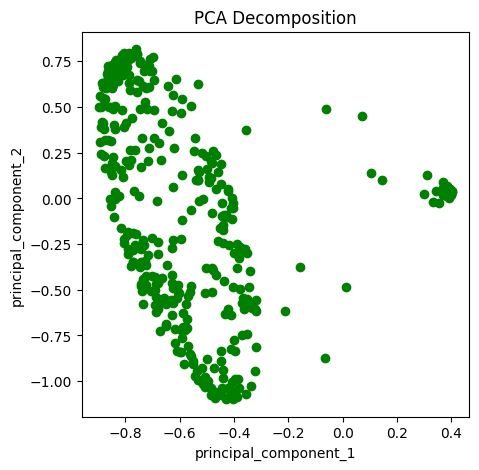

In [615]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(df_item_pca['principal_component_1'],
            df_item_pca['principal_component_2'],
            color='g')
plt.xlabel('principal_component_1')
plt.ylabel('principal_component_2')
plt.title('PCA Decomposition')
plt.show()

Plotting the dataset in 3D after PCA transformation (Plotando o dataset em 3D após a transformação do PCA).

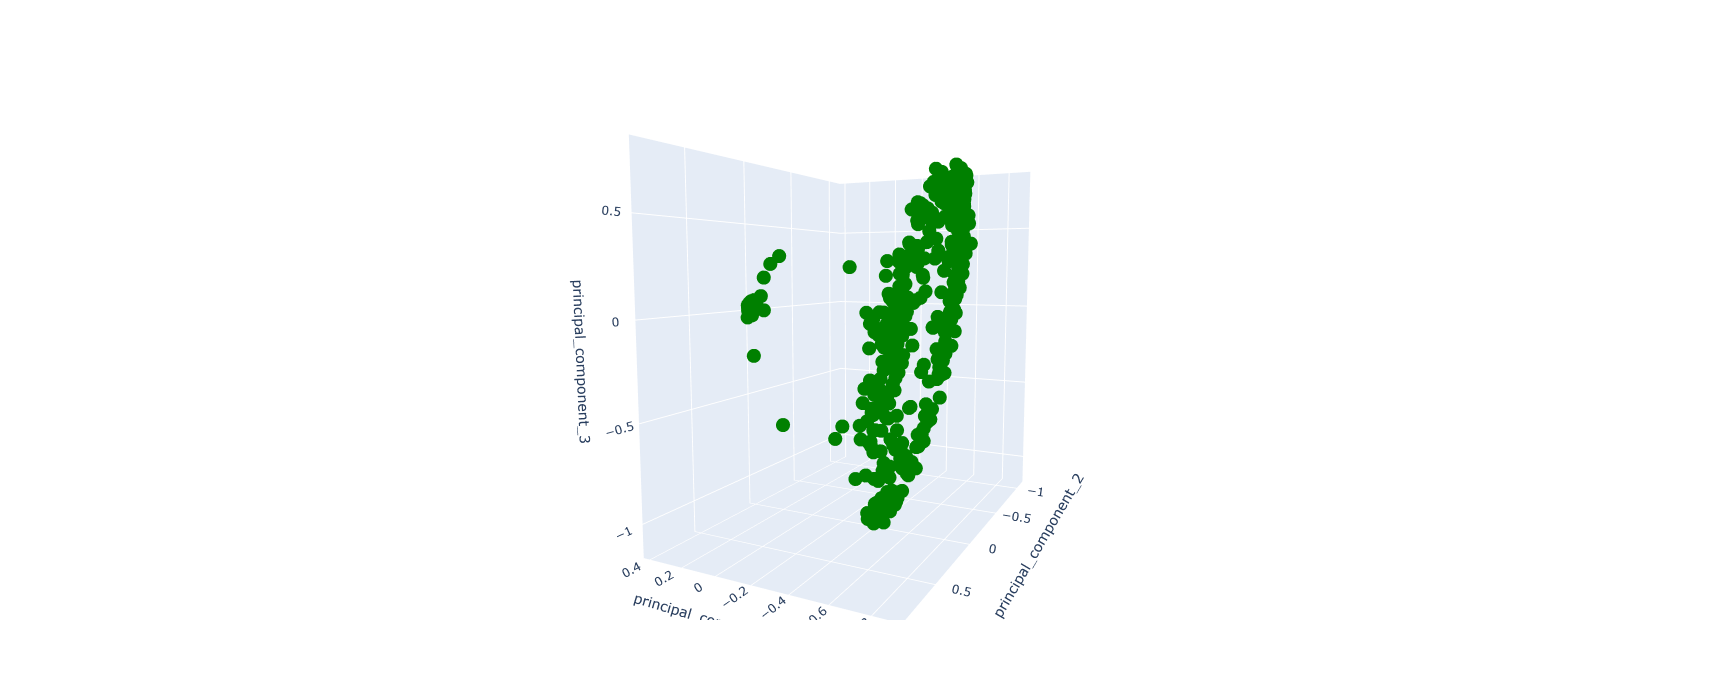

In [613]:
fig = px.scatter_3d(df_item_pca,
                    x='principal_component_1',
                    y='principal_component_2',
                    z='principal_component_3',
                    width=800,
                    height=700).update_traces(marker=dict(color='green'))
fig.show()

<a name="5"></a>
## Recommendation (Recomendação)
**[EN-US]**

Recommending the songs from the defined playlist, in this case, the playlist with the top 50 global Spotify songs, `Top 50 - Global`, to add the recommended songs to a Spotify playlist for consumption.

**[PT-BR]**

Recomendando as músicas da playlist definida, nesse caso, a playlist com as top 50 músicas globais do spotify, `Top 50 - Mundo`, para adicionar as músicas recomendadas em uma playlist do spotify para consumo.

<a name='5.1'></a>
### Environment Variables (Variáveis de Ambiente)
**[EN-US]**

Setting the environment variables:
* `CLIENT_ID_SPOTIFY`: the client ID generated after registering your application.
* `CLIENT_SECRET_SPOTIFY`: the client secret generated after registering your application.

**[PT-BR]**

Definindo as variáveis de ambiente:
* `CLIENT_ID_SPOTIFY`: o cliente ID gerado após registrar seu aplicativo.
* `CLIENT_SECRET_SPOTIFY`: o client secret gerado após o registro do seu aplicativo.

In [247]:
CLIENT_ID = os.environ['CLIENT_ID_SPOTIFY']
CLIENT_SECRET = os.environ['CLIENT_SECRET_SPOTIFY']

<a name="5.2"></a>
### Request Authorization (Requisitando a Autorização)
Requesting Spotify Authorization (Requisitando a autorização do Spotify).

In [ ]:
access_token, token_type, token_expires = request_auth(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)

In [ ]:
print(f'The token expires in: {token_expires}s')

<a name="5.3"></a>
### Playlists Definition (Definição das Playlists)
Setting the playlist to be extracted for inference in the model (Definindo a playlist que será extraida para inferência no modelo).

In [ ]:
playlist = 'https://open.spotify.com/playlist/37i9dQZEVXbMDoHDwVN2tF?si=e850a816edf44117'

<a name="5.4"></a>
### Extract, Transform and Preprocessing the Data (Extração, Transformação e Pré-processamento dos Dados)
Extracting playlist data for recommendation, transforming and preprocessing the data for inference (Extraindo os dados da playlist para recomendação, transformando e pré-processando os dados).

Extract (Extração)

In [ ]:
df_rec = playlist_to_dataframe(playlist, token_type, access_token)

Transform (Transformação)

In [ ]:
# Creating the `duration_min` feature (Criando a feature `duration_min`).
df_rec['duration_min'] = df_rec['duration_ms'] / 60000
# Setting the dataset with only the track ID, song and artist names
# Definindo o dataset apenas com o ID das tracks, os nomes das músicas e dos artistas
items_rec = df_rec.iloc[:, :3].copy()

Preprocessing the dataset for recommendations for inference in the model (Pré-processando o dataset para as recomendações para a inferência no modelo).

In [ ]:
# Creating a dataset with only numerical features
# Criando um dataset apenas com as features numéricas
X_rec_num = df_rec.drop(columns=['id', 'name', 'artists', 'duration_ms']).copy()
X_rec_num.head()

**[EN-US]**

Creating the one-hot encoding of the `key` feature. The `key` feature represents the key the track is in. 0 = C, 1 = C♯/D♭, 2 = D and so on. If no key is detected, the value will be -1. Therefore, the values ​​of this feature are not odinal, they are nominal, that is, the classes are not ordered, they do not have an intrinsic order and we do not establish a hierarchy between them. Then, concatenating the numeric dataset `X_rec_num` with the one-hot encoding of the `key` feature.

**[PT-BR]**

Criando o one-hot encoding da feature `key`. A fetura `key` representa o tom em que a track está. 0 = C, 1 = C♯/D♭, 2 = D e assim por diante. Se nenhuma chave for detectada, o valor será -1. Portanto, os valores dessa feature não é odinal, é nominal, ou seja, as classes não são ordenadas, não têm um ordem intrínseca e não estabelecemos uma hierarquia entre elas. Em seguida, concatenando o dataset numérico `X_rec_num` com o one-hot enconding da feature `key`.

In [ ]:
# Creating the one-hot encoding (Criando o one-hot encoding).
key_oh = pd.get_dummies(X_rec_num['key'], prefix='key', drop_first=True, dtype=np.int64)

# Setting the numeric dataset without the feature key
# Definindo o dataset numérico sem a feature key
X_rec_num_wkey = X_rec_num.drop(columns=['key']).copy()
# Looping through the dataset columns X_num_key and key_oh to define them as feature names
# Percorrendo as colunas do dataset X_num_key e do key_oh para definí-las como nomes das features
columns_oh = {i: j for i, j in enumerate(X_rec_num_wkey.columns.tolist() + key_oh.columns.tolist())}

# Concatenating the datasets
# Concatenando os datasets
X_rec_num_oh = pd.concat(
    [X_rec_num_wkey, key_oh],
    axis=1,
    ignore_index=True,
).rename(columns=columns_oh)
# Plotting the first 5 examples of the concatenated dataset
# Plotando os 5 primeiros exemplos do dataset concatenado
X_rec_num_oh.head()

Setting the user dataset (Definindo o dataset do usuário)

In [ ]:
user_set = pd.read_csv('../data/preprocessed/user_train_norm.csv').iloc[:1, :]
user_rec = get_user_dataset(
    user_set,
    X_rec_num
)
user_rec.head()

Applying z-score normalization. We calculate the mean and standard deviation of the training set, and then apply the z-score to the recommender dataset with the mean and standard deviation of the training set (Aplicando a normalização z-score. Calculamos a média e desvio-padrão do training set, e então, aplicamos o z-score para o dataset de recomendação com a média e o desvio-padrão do training set).
$$X = \frac{X - \mu}{\sigma^2}$$
* $\mu$: mean (média).
* $\sigma^2$: standard deviation (desvio-padrão).



In [ ]:
item_train = pd.read_csv('../data/preprocessed/item_train_norm.csv')

item_scaler = StandardScaler()
item_train_norm = item_scaler.fit_transform(item_train)
item_rec_norm = item_scaler.transform(X_rec_num_oh)

Plotting the preprocessed dataset (Plotando o dataset pré-processado).

In [ ]:
item_rec_norm.head()

<a name="5.5"></a>
### Inference (Inferência)
Running inference on the model (Executando a inferência no modelo).

In [ ]:
y_hat_rec = model.predict(
    [user_rec, item_rec_norm],
    verbose=0
)
y_hat_rec[:10]

Plotting the top $m$ recommendations on the recommender data (Plotando as $m$ primeiras recomendações sobre os dados de recomendações).

In [ ]:
m = 10

# Sorting the vector with the predictions in descending order and selecting only the indexes
# Ordenando o vetor com as previsões em ordem decrescente e selecionando apenas os índices
sorted_idx_rec = np.argsort(-y_hat_rec, axis=0).squeeze().tolist()
# Slicing the recommended indexes in the recommender items dataset, to sort it in the same order
# Selecionando os índices recomendados no dataset de items de recomendações, para ordená-lo na mesma ordem
sorted_items_rec = items_rec.iloc[sorted_idx_rec].reset_index().drop(columns=['index']).copy()
# Plotting the top m recommended items
# Plotando os top m items recomendados
sorted_items_rec.head(m)

<a name="6"></a>
## Load Tracks (Carregando as Tracks)
**[EN-US]**

We will save the recommended songs to a Spotify playlist.

**[PT-BR]**

Salvaremos as músicas recomendadas em uma playlist do Spotify.

Requesting User ID (Requisitando o ID do usuário).

In [ ]:
user_id = get_user(token_type, access_token)

Creating the playlist where the tracks will be added (Criando a playlist onde as tracks serão adicionadas).

In [ ]:
playlist_id = create_playlist(user_id, token_type, access_token)

Adding tracks to the playlist (Adicionando as tracks na playlist).

In [ ]:
# Turning the uris of recommended tracks into a list
# Transformando os uris das tracks recomendadas em uma lista
uris = items_rec.loc[sorted_idx_rec, 'uri'].tolist()
add_tracks(playlist_id, uris, token_type, access_token)